# ECE 4580 Convolutional Neural Networks (CNNs)
---
[![CNN_IMAGE](CNN2.png)](https://www.geeksforgeeks.org/deep-learning/convolutional-neural-network-cnn-in-machine-learning/)

CNNs are the backbone of modern computer vision. Unlike fully connected networks, CNNs exploit the **spatial structure** of images through local connectivity and weight sharing — making them dramatically more efficient and effective.

### Topics Covered
1. Motivation — Why not just use fully connected networks?
2. The Convolution Operation
3. Padding & Stride
4. Pooling Layers
5. Activation Functions
6. Full CNN Architecture
7. Building a CNN with PyTorch
8. Visualizing Learned Filters & Feature Maps
9. Classic Architectures (LeNet, AlexNet, VGG, ResNet)
10. Transfer Learning Example

Let's start using Googe Colab
https://colab.research.google.com/

In [1]:
# ── Standard imports ──────────────────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
from scipy.signal import convolve2d
import warnings
warnings.filterwarnings('ignore')

# Optional deep‑learning imports (notebook degrades gracefully without them)
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import torchvision
    import torchvision.transforms as transforms
    from torchvision import datasets
    TORCH_AVAILABLE = True
    print(f"PyTorch {torch.__version__} available — GPU: {torch.cuda.is_available()}")
except ImportError:
    TORCH_AVAILABLE = False
    print("PyTorch not found — conceptual cells will still run.")

plt.rcParams.update({'font.size': 12, 'figure.dpi': 110})

PyTorch 2.7.1+cu118 available — GPU: True


---
## 1. Motivation — The Problem with Fully Connected Networks

A **32×32 RGB image** has 3,072 input values. A single hidden layer of 1,000 neurons requires **3,072,000 weights** — just for the first layer. For a 224×224 image that balloons to **150 million weights per layer**.

**Key problems:**
- Astronomically many parameters → overfitting
- Ignores spatial structure (a pixel at (0,0) is treated identically to one at (100,100))
- Not translation invariant — a shifted object looks completely different

**CNNs solve this with three ideas:**
1. **Local connectivity** — each neuron only sees a small receptive field
2. **Weight sharing** — the same filter is applied everywhere
3. **Pooling** — progressively reduce spatial resolution

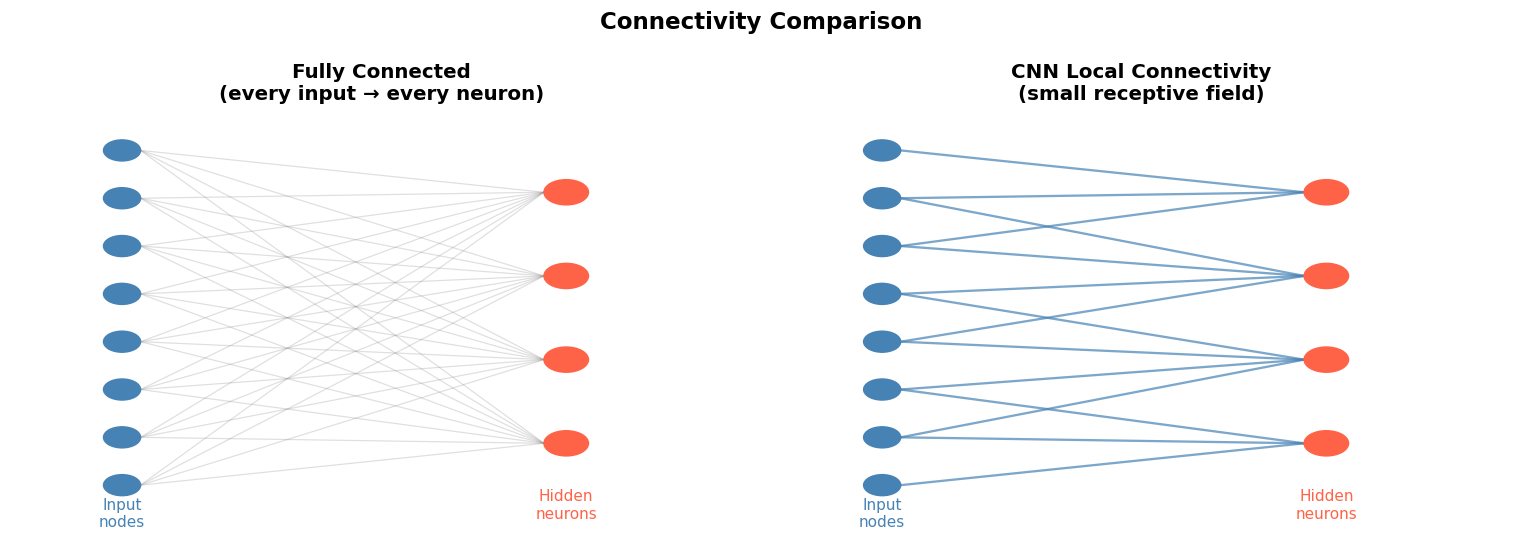

In [21]:
# ── Visualize: FC vs CNN connectivity ─────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, title, connected in zip(axes,
    ['Fully Connected\n(every input → every neuron)', 'CNN Local Connectivity\n(small receptive field)'],
    [True, False]):

    n_inputs  = 8
    n_neurons = 4
    input_y   = np.linspace(0.1, 0.9, n_inputs)
    neuron_y  = np.linspace(0.2, 0.8, n_neurons)

    # Input nodes
    for y in input_y:
        ax.add_patch(plt.Circle((0.15, y), 0.025, color='steelblue', zorder=3))
    # Neuron nodes
    for y in neuron_y:
        ax.add_patch(plt.Circle((0.75, y), 0.030, color='tomato', zorder=3))

    # Connections
    if connected:
        for iy in input_y:
            for ny in neuron_y:
                ax.plot([0.175, 0.720], [iy, ny], 'gray', alpha=0.25, lw=0.8)
    else:
        # Each neuron connects to only 3 nearby inputs
        receptive = 3
        for j, ny in enumerate(neuron_y):
            center = int(j * (n_inputs / n_neurons))
            for k in range(max(0, center-1), min(n_inputs, center+receptive)):
                ax.plot([0.175, 0.720], [input_y[k], ny], 'steelblue', alpha=0.7, lw=1.5)

    ax.set_xlim(0, 1); ax.set_ylim(0, 1)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.axis('off')
    ax.text(0.15, 0.00, 'Input\nnodes', ha='center', fontsize=10, color='steelblue')
    ax.text(0.75, 0.02, 'Hidden\nneurons', ha='center', fontsize=10, color='tomato')

plt.suptitle('Connectivity Comparison', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 2. The Convolution Operation

The core operation is **cross-correlation** (often loosely called convolution):

$$\mathbf{O}[i,j] = \sum_{m=0}^{k-1}\sum_{n=0}^{k-1} \mathbf{I}[i+m,\; j+n] \cdot \mathbf{K}[m,n]$$

where **I** is the input image, **K** is the kernel (filter), and **O** is the output feature map.

### Output size
$$H_{out} = \frac{H_{in} - k + 2p}{s} + 1, \qquad W_{out} = \frac{W_{in} - k + 2p}{s} + 1$$

- $k$ = kernel size, $p$ = padding, $s$ = stride

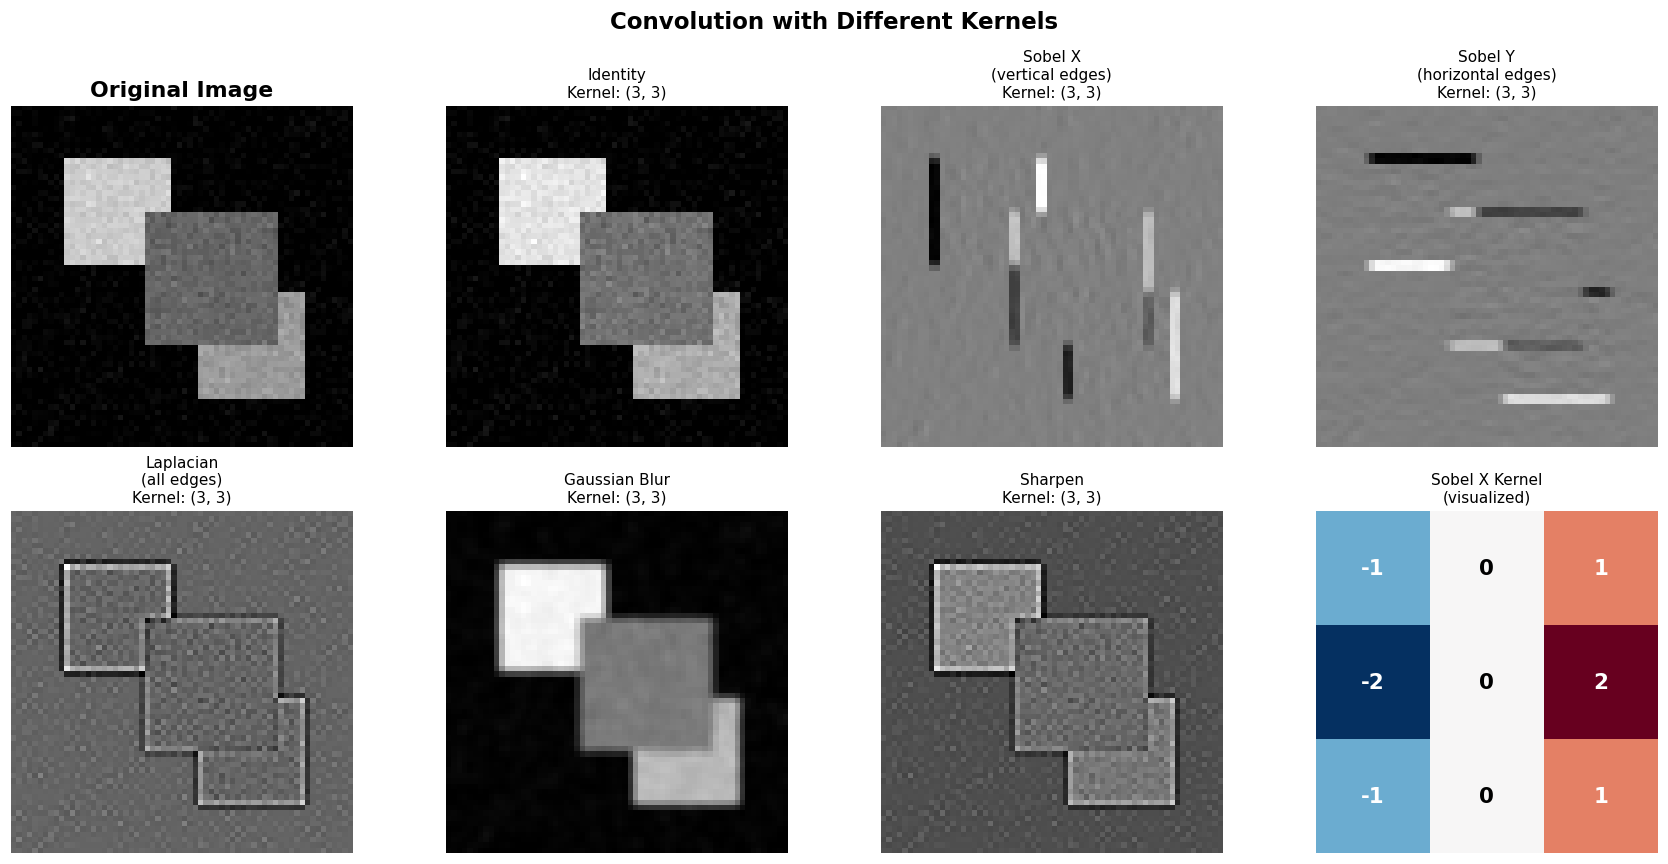

In [3]:
# ── Demonstrate convolution with classic edge‑detection kernels ───────────────
from matplotlib.image import imread

# Create a simple synthetic grayscale test image
def make_test_image(n=64):
    img = np.zeros((n, n))
    img[10:30, 10:30] = 0.8          # bright square
    img[35:55, 35:55] = 0.6
    img[20:45, 25:50] = 0.4
    rng = np.random.default_rng(42)
    img += rng.normal(0, 0.03, img.shape)
    return np.clip(img, 0, 1)

img = make_test_image()

# Define kernels
kernels = {
    'Identity':      np.array([[0,0,0],[0,1,0],[0,0,0]], dtype=float),
    'Sobel X\n(vertical edges)': np.array([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=float),
    'Sobel Y\n(horizontal edges)': np.array([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=float),
    'Laplacian\n(all edges)':  np.array([[0,-1,0],[-1,4,-1],[0,-1,0]], dtype=float),
    'Gaussian Blur': np.array([[1,2,1],[2,4,2],[1,2,1]], dtype=float)/16,
    'Sharpen':       np.array([[0,-1,0],[-1,5,-1],[0,-1,0]], dtype=float),
}

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes[0, 0].imshow(img, cmap='gray', vmin=0, vmax=1)
axes[0, 0].set_title('Original Image', fontweight='bold')
axes[0, 0].axis('off')

for ax, (name, K) in zip(axes.flat[1:], kernels.items()):
    result = convolve2d(img, K, mode='same', boundary='symm')
    ax.imshow(result, cmap='gray')
    ax.set_title(f'{name}\nKernel: {K.shape}', fontsize=10)
    ax.axis('off')

# Show one kernel visually
axes[1, 3].imshow(kernels['Sobel X\n(vertical edges)'], cmap='RdBu_r')
axes[1, 3].set_title('Sobel X Kernel\n(visualized)', fontsize=10)
for (r, c), val in np.ndenumerate(kernels['Sobel X\n(vertical edges)']):
    axes[1, 3].text(c, r, f'{int(val)}', ha='center', va='center',
                    fontsize=14, fontweight='bold',
                    color='white' if abs(val) > 0.5 else 'black')
axes[1, 3].axis('off')

plt.suptitle('Convolution with Different Kernels', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

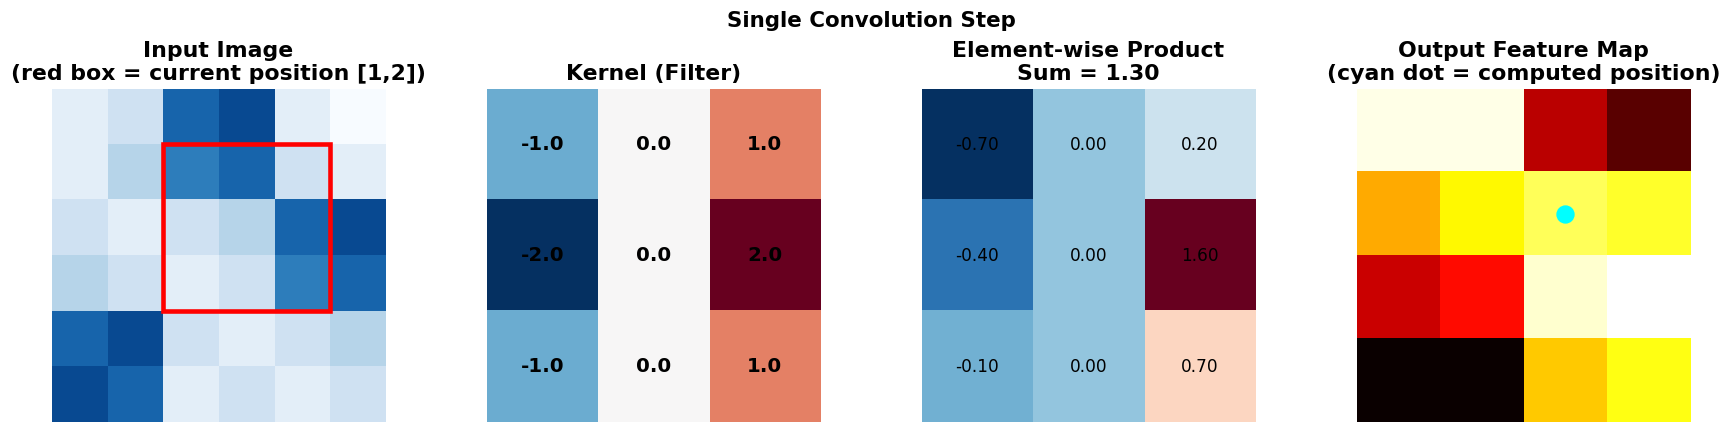

In [4]:
# ── Step-by-step convolution animation (static visualization) ─────────────────
def visualize_convolution_step(image, kernel, step_r=1, step_c=2):
    """Show a single convolution step — sliding kernel over image."""
    k = kernel.shape[0]
    H, W = image.shape
    out_H = H - k + 1
    out_W = W - k + 1
    output = np.zeros((out_H, out_W))

    for i in range(out_H):
        for j in range(out_W):
            output[i, j] = np.sum(image[i:i+k, j:j+k] * kernel)

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    # Image with kernel position highlighted
    axes[0].imshow(image, cmap='Blues', vmin=0, vmax=1)
    rect = mpatches.Rectangle((step_c-0.5, step_r-0.5), k, k,
                                linewidth=3, edgecolor='red', facecolor='none')
    axes[0].add_patch(rect)
    axes[0].set_title(f'Input Image\n(red box = current position [{step_r},{step_c}])', fontweight='bold')

    # Kernel
    im = axes[1].imshow(kernel, cmap='RdBu_r')
    for (r, c), val in np.ndenumerate(kernel):
        axes[1].text(c, r, f'{val:.1f}', ha='center', va='center', fontsize=13, fontweight='bold')
    axes[1].set_title('Kernel (Filter)', fontweight='bold')

    # Patch being multiplied
    patch = image[step_r:step_r+k, step_c:step_c+k]
    axes[2].imshow(patch * kernel, cmap='RdBu_r')
    for (r, c), val in np.ndenumerate(patch * kernel):
        axes[2].text(c, r, f'{val:.2f}', ha='center', va='center', fontsize=11)
    axes[2].set_title(f'Element‑wise Product\nSum = {np.sum(patch*kernel):.2f}', fontweight='bold')

    # Output feature map
    axes[3].imshow(output, cmap='hot')
    axes[3].plot(step_c, step_r, 'o', color='cyan', markersize=10, markeredgewidth=2)
    axes[3].set_title('Output Feature Map\n(cyan dot = computed position)', fontweight='bold')

    for ax in axes:
        ax.axis('off')

    plt.suptitle('Single Convolution Step', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    return output

# Small 6x6 image for clarity
small_img = np.array([
    [0.1, 0.2, 0.8, 0.9, 0.1, 0.0],
    [0.1, 0.3, 0.7, 0.8, 0.2, 0.1],
    [0.2, 0.1, 0.2, 0.3, 0.8, 0.9],
    [0.3, 0.2, 0.1, 0.2, 0.7, 0.8],
    [0.8, 0.9, 0.2, 0.1, 0.2, 0.3],
    [0.9, 0.8, 0.1, 0.2, 0.1, 0.2],
], dtype=float)

sobel_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=float)
_ = visualize_convolution_step(small_img, sobel_x, step_r=1, step_c=2)

---
## 3. Padding & Stride

### Padding
- **`valid`** (no padding): output shrinks by $k-1$ per dimension
- **`same`** (zero-padding): output size = input size (when stride=1)

### Stride
Stride $s > 1$ skips positions, reducing output size and computation.

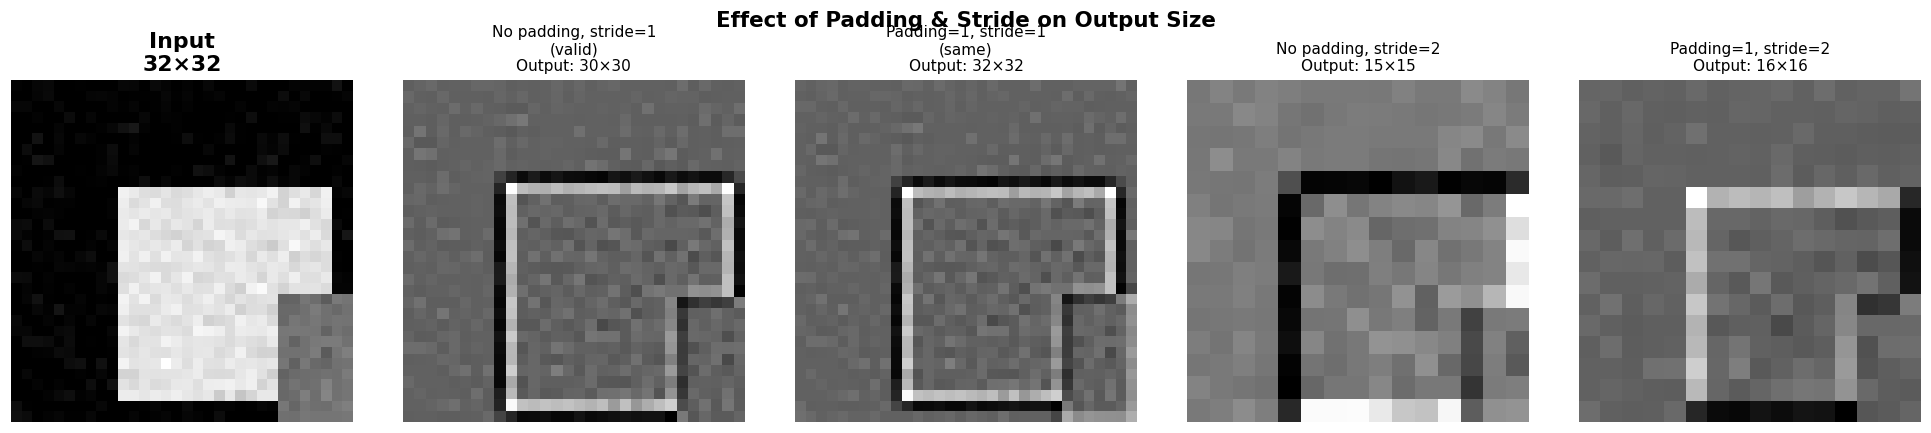

Output size formula: floor((H + 2p - k) / s) + 1
  No padding, stride=1           → 30×30
  Padding=1, stride=1            → 32×32
  No padding, stride=2           → 15×15
  Padding=1, stride=2            → 16×16


In [5]:
# ── Visualize effect of padding and stride ────────────────────────────────────
def apply_conv(img, kernel, stride=1, padding=0):
    if padding > 0:
        img = np.pad(img, padding, mode='constant')
    k = kernel.shape[0]
    H, W = img.shape
    out_H = (H - k) // stride + 1
    out_W = (W - k) // stride + 1
    out = np.zeros((out_H, out_W))
    for i in range(0, out_H):
        for j in range(0, out_W):
            out[i, j] = np.sum(img[i*stride:i*stride+k, j*stride:j*stride+k] * kernel)
    return out

configs = [
    ('No padding, stride=1\n(valid)', 0, 1),
    ('Padding=1, stride=1\n(same)', 1, 1),
    ('No padding, stride=2', 0, 2),
    ('Padding=1, stride=2', 1, 2),
]

src = make_test_image(32)
K = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]], dtype=float)  # edge kernel

fig, axes = plt.subplots(1, 5, figsize=(18, 4))
axes[0].imshow(src, cmap='gray')
axes[0].set_title(f'Input\n{src.shape[0]}×{src.shape[1]}', fontweight='bold')
axes[0].axis('off')

for ax, (title, pad, stride) in zip(axes[1:], configs):
    out = apply_conv(src, K, stride=stride, padding=pad)
    ax.imshow(out, cmap='gray')
    ax.set_title(f'{title}\nOutput: {out.shape[0]}×{out.shape[1]}', fontsize=10)
    ax.axis('off')

plt.suptitle('Effect of Padding & Stride on Output Size', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Output size formula: floor((H + 2p - k) / s) + 1")
for title, p, s in configs:
    H = 32; k = 3
    out = (H + 2*p - k) // s + 1
    print(f"  {title.split(chr(10))[0]:30s} → {out}×{out}")

---
## 4. Pooling Layers

Pooling **reduces spatial dimensions**, providing:
- Translation invariance
- Reduced computation and memory
- Larger receptive fields in deeper layers

| Type | Operation |
|------|----------|
| **Max Pooling** | Take the maximum value in the window |
| **Average Pooling** | Take the mean of values in the window |
| **Global Average Pooling** | Single average per feature map (used before classifier) |

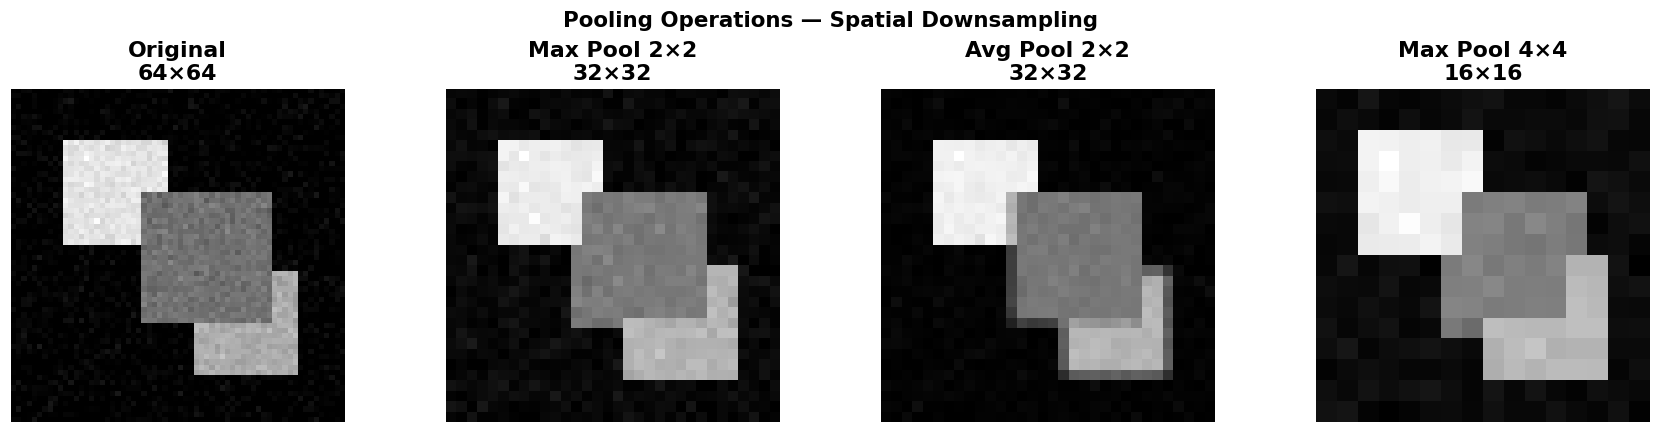


Numerical Example — 4×4 input, 2×2 max pool (stride=2)
Input:
 [[1. 3. 2. 4.]
 [5. 6. 7. 8.]
 [3. 2. 1. 0.]
 [1. 2. 3. 4.]]
Max Pool Output:
 [[6. 8.]
 [3. 4.]]
Avg Pool Output:
 [[3.75 5.25]
 [2.   2.  ]]


In [6]:
# ── Visualize Max Pooling vs Average Pooling ──────────────────────────────────
def pool2d(img, size=2, mode='max'):
    H, W = img.shape
    out = np.zeros((H//size, W//size))
    for i in range(H//size):
        for j in range(W//size):
            patch = img[i*size:(i+1)*size, j*size:(j+1)*size]
            out[i, j] = patch.max() if mode == 'max' else patch.mean()
    return out

src = make_test_image(64)
max_p2 = pool2d(src, 2, 'max')
avg_p2 = pool2d(src, 2, 'avg')
max_p4 = pool2d(src, 4, 'max')

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for ax, data, title in zip(axes,
    [src, max_p2, avg_p2, max_p4],
    ['Original\n64×64', 'Max Pool 2×2\n32×32', 'Avg Pool 2×2\n32×32', 'Max Pool 4×4\n16×16']):
    ax.imshow(data, cmap='gray', interpolation='nearest')
    ax.set_title(title, fontweight='bold')
    ax.axis('off')

plt.suptitle('Pooling Operations — Spatial Downsampling', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Show numerical example
print("\nNumerical Example — 4×4 input, 2×2 max pool (stride=2)")
ex = np.array([[1,3,2,4],[5,6,7,8],[3,2,1,0],[1,2,3,4]], dtype=float)
print("Input:\n", ex)
print("Max Pool Output:\n", pool2d(ex, 2, 'max'))
print("Avg Pool Output:\n", pool2d(ex, 2, 'avg'))

---
## 5. Activation Functions

After each convolution, a **non-linear activation** is applied element-wise to introduce non-linearity.

|<div style="width:150px"> Function </div> | <div style="width:150px">Formula</div> | Notes |
|:----------|:---------|:-------|
| **Rectified Linear Unit (ReLU)** | $\max(0, x)$ | Most common; avoids vanishing gradient |
| **Leaky ReLU** | $x$ if $x>0$ else $0.01x$ | Fixes dying ReLU |
| **Exponential Linear Unit (ELU)** | $x$ if $x>0$ else $\alpha(e^x-1)$ | Smoother, negative saturation |
| **Sigmoid** | $1/(1+e^{-x})$ | Historically used; now mainly output layers |
| **Gaussian Error Linear Unit (GELU)** | $x\Phi(x)$ | Used in transformers; smooth |
| **Swish** | $x \cdot \sigma(x)$ | Self-gated; often beats ReLU |

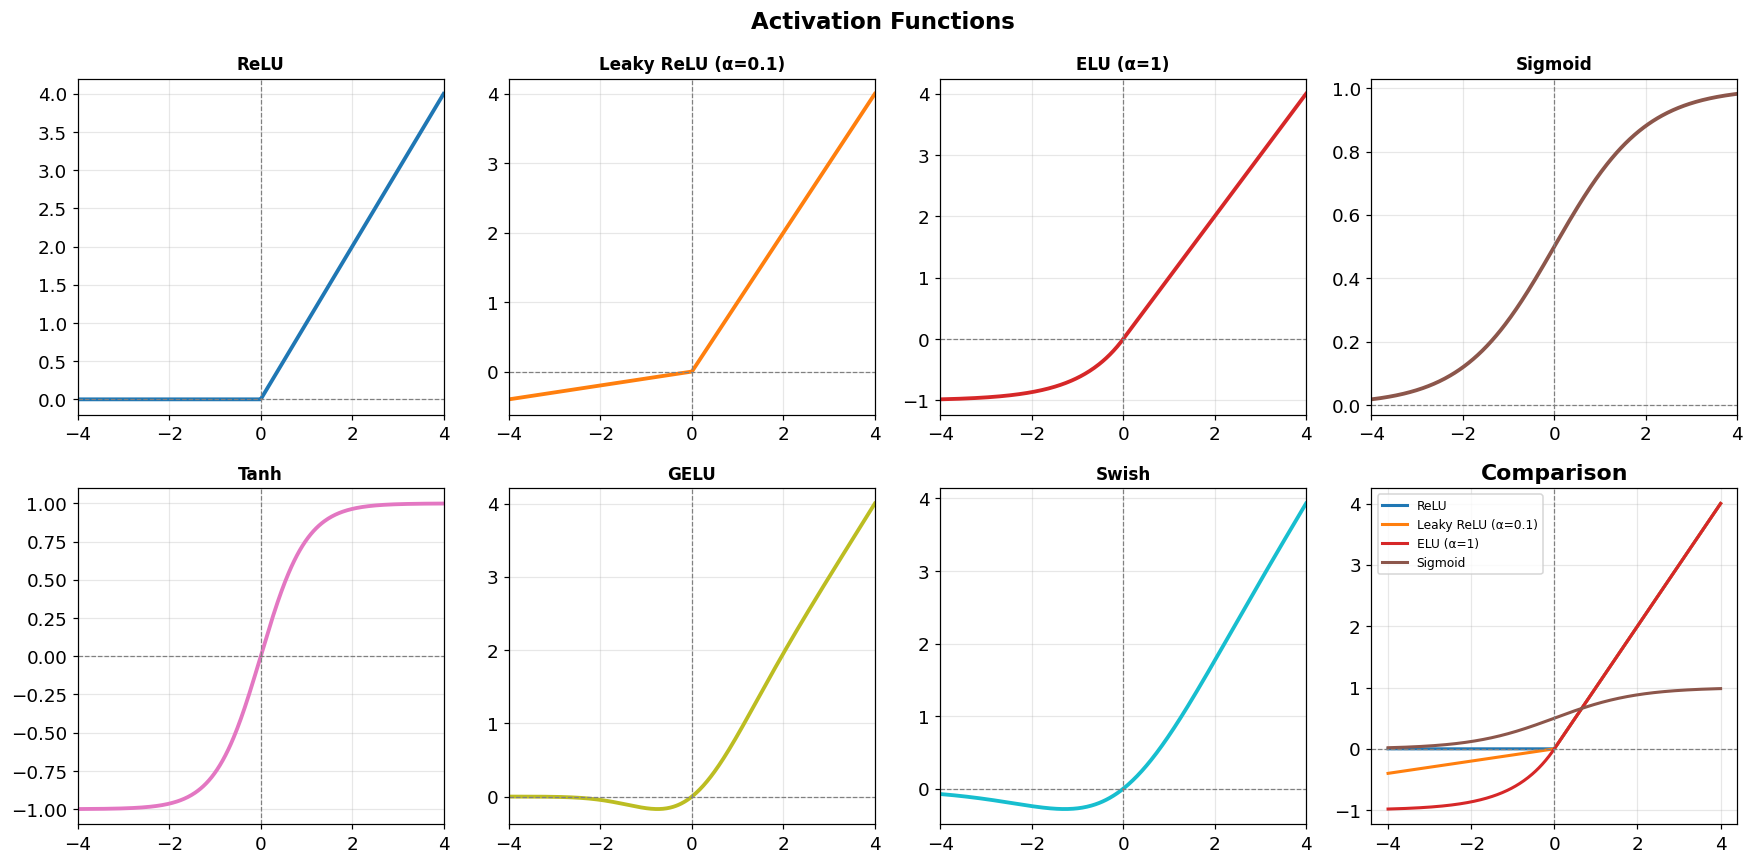

In [7]:
# ── Plot activation functions ─────────────────────────────────────────────────
x = np.linspace(-4, 4, 400)

activations = {
    'ReLU': np.maximum(0, x),
    'Leaky ReLU (α=0.1)': np.where(x > 0, x, 0.1*x),
    'ELU (α=1)': np.where(x > 0, x, np.exp(x) - 1),
    'Sigmoid': 1 / (1 + np.exp(-x)),
    'Tanh': np.tanh(x),
    'GELU': x * 0.5 * (1 + np.tanh(np.sqrt(2/np.pi)*(x + 0.044715*x**3))),
    'Swish': x / (1 + np.exp(-x)),
}

colors = plt.cm.tab10(np.linspace(0, 1, len(activations)))

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for ax, (name, y), c in zip(axes.flat, activations.items(), colors):
    ax.plot(x, y, color=c, lw=2.5)
    ax.axhline(0, color='gray', lw=0.8, ls='--')
    ax.axvline(0, color='gray', lw=0.8, ls='--')
    ax.set_title(name, fontweight='bold', fontsize=11)
    ax.set_xlim(-4, 4)
    ax.grid(True, alpha=0.3)

# Comparison
ax = axes.flat[-1]
for (name, y), c in zip(list(activations.items())[:4], colors):
    ax.plot(x, y, color=c, lw=2, label=name)
ax.legend(fontsize=8)
ax.set_title('Comparison', fontweight='bold')
ax.axhline(0, color='gray', lw=0.8, ls='--')
ax.axvline(0, color='gray', lw=0.8, ls='--')
ax.grid(True, alpha=0.3)

plt.suptitle('Activation Functions', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 6. Full CNN Architecture: A Detailed Guide

A Convolutional Neural Network (CNN) is a class of deep neural network most commonly applied to visual data. It learns a hierarchy of features — from low-level edges and textures to high-level semantic concepts — through a sequence of structured layers. The overall architecture can be divided into two major stages: **Feature Extraction** and **Classification**.

```
Input Image
    │
    ▼
[Conv → BN → ReLU → Pool] × N   ← Feature Extraction
    │
    ▼
Flatten / Global Average Pool
    │
    ▼
[Fully Connected → Dropout] × M  ← Classifier Head
    │
    ▼
Softmax → Class Probabilities
```

---

### 6.1. Input Image

The network receives a raw image tensor of shape **(H × W × C)**, where:

- **H** = height in pixels
- **W** = width in pixels
- **C** = number of channels (1 for grayscale, 3 for RGB)

Images are typically preprocessed before entering the network:

- **Normalization** — pixel values are scaled from [0, 255] to [0, 1] or standardized to zero mean and unit variance using dataset statistics (e.g., ImageNet mean/std).
- **Resizing** — images are resized to a fixed spatial resolution expected by the network (e.g., 224×224 for VGG/ResNet).
- **Data Augmentation** — random crops, flips, rotations, color jitter, and other transforms are applied during training to improve generalization.

---

### 6.2. Feature Extraction: [Conv → BN → ReLU → Pool] × N

This block repeats **N** times, with each repetition increasing the semantic richness of the learned representations while reducing spatial resolution.

---

#### 6.2.1 Convolutional Layer (Conv)

The convolutional layer is the core building block of a CNN. It applies a set of learnable **filters (kernels)** to the input, producing a set of **feature maps**.

**Operation:**

For a 2D input and a single filter **K** of size (k × k):

$$(\mathbf{I} * \mathbf{K})(i, j) = \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} \mathbf{I}(i+m,\ j+n) \cdot \mathbf{K}(m, n)$$

Each filter slides across the entire spatial extent of the input, computing dot products at every position to produce one feature map. With **F** filters, the output has **F** channels — each representing a different learned feature detector.

**Key hyperparameters:**

- **Filter size (k)** — typically 3×3 or 5×5; smaller filters are preferred in modern architectures as they reduce parameters while stacking multiple layers achieves the same receptive field as larger filters.
- **Number of filters (F)** — determines the depth of the output feature map; common values are 32, 64, 128, 256, 512.
- **Stride (s)** — how many pixels the filter moves at each step; stride > 1 reduces spatial dimensions.
- **Padding (p)** — zeros added around the input border; "same" padding preserves spatial dimensions, "valid" padding does not.

**Output spatial dimensions:**

$$H_{out} = \left\lfloor \frac{H_{in} - k + 2p}{s} \right\rfloor + 1$$

**Why convolutions work:**

- **Parameter sharing** — the same filter is applied everywhere, drastically reducing parameters compared to a fully connected layer.
- **Translation equivariance** — a feature detected in one location can be detected anywhere in the image using the same weights.
- **Local connectivity** — each neuron only connects to a small local region of the input, exploiting the spatial structure of images.

---

#### 6.2.2 Batch Normalization (BN)

Batch Normalization, introduced by Ioffe & Szegedy (2015), normalizes the activations of a layer across the current mini-batch. It is applied after convolution and before the activation function.

**Operation:**

During training, rather than feeding the entire dataset through the network at once (too slow) or one sample at a time (too noisy), we process a **mini-batch** of **m** samples simultaneously. BN operates on the activations produced by those **m** samples at a particular layer.

For concreteness, imagine a convolutional layer that outputs a feature map. After convolution, you have a set of activations — one per sample in the batch. BN looks at those **m** activation values **for a single feature/channel** and normalizes them as a group.

Let the activations for one feature across the mini-batch be:

$$\mathcal{B} = \{x_1, x_2, \ldots, x_m\}$$

---

##### Step 1: Mini-Batch Mean

$$\mu_B = \frac{1}{m} \sum_{i=1}^{m} x_i$$

This is simply the **arithmetic mean** of all m activation values in the batch for this feature.

**What it tells you:** The average "center" of the activations. If activations are clustered around 5.0, then μ_B ≈ 5.0.

**Why compute it:** We want to **center** the distribution around zero. By subtracting the mean in Step 3, we shift the entire distribution so its center lands at 0, regardless of where the raw activations happened to be.

**Example:** Suppose m = 4 and the activations are {2, 4, 6, 8}:

$$\mu_B = \frac{2 + 4 + 6 + 8}{4} = 5.0$$

---

##### Step 2: Mini-Batch Variance

$$\sigma_B^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu_B)^2$$

This is the **variance** of the activations — the average squared deviation from the mean.

**Breaking it down piece by piece:**

- $(x_i - \mu_B)$ — how far each activation is from the mean (its deviation)
- $(x_i - \mu_B)^2$ — squaring makes all deviations positive and penalizes large ones more heavily
- $\frac{1}{m} \sum \ldots$ — average over all m samples

**What it tells you:** How **spread out** the activations are. A large variance means activations are widely scattered; a small variance means they're tightly clustered.

**Why compute it:** We use it in Step 3 to **scale** the distribution so its spread becomes roughly unit width (standard deviation ≈ 1).

**Continuing the example** with {2, 4, 6, 8} and μ_B = 5.0:

$$\sigma_B^2 = \frac{(2-5)^2 + (4-5)^2 + (6-5)^2 + (8-5)^2}{4} = \frac{9 + 1 + 1 + 9}{4} = 5.0$$

---

##### Step 3: Normalize

$$\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$$

This is the core normalization step. Let's dissect every part:

**Numerator — $(x_i - \mu_B)$:**

Subtracts the mean from each activation, **centering** the distribution at zero. An activation that was at the mean becomes 0; one above the mean becomes positive; one below becomes negative.

**Denominator — $\sqrt{\sigma_B^2 + \epsilon}$:**

This is essentially the **standard deviation** of the batch. Dividing by it **scales** the distribution so the spread is normalized to approximately 1.

- If activations have a large spread (σ_B = 10), the denominator is large and values get compressed.
- If activations are tightly clustered (σ_B = 0.1), the denominator is small and values get expanded.

**The ε (epsilon) term:**

A very small constant, typically **1e-5**, added inside the square root for two reasons:

1. **Numerical stability** — prevents division by zero if all activations in the batch happen to be identical (σ_B² = 0).
2. **Smooth gradient** — avoids the near-zero denominator that would produce extremely large (and unstable) gradients during backpropagation.

**Result:** $\hat{x}_i$ now has approximately **zero mean and unit variance** across the mini-batch.

**Continuing the example** with {2, 4, 6, 8}, μ_B = 5.0, σ_B² = 5.0 (ignoring ε):

$$\hat{x}_1 = \frac{2 - 5}{\sqrt{5}} = \frac{-3}{2.236} \approx -1.342$$

$$\hat{x}_2 = \frac{4 - 5}{\sqrt{5}} \approx -0.447, \quad \hat{x}_3 \approx +0.447, \quad \hat{x}_4 \approx +1.342$$

The normalized values are centered at 0 with spread ≈ 1. ✓

---

##### Step 4: Scale and Shift

$$y_i = \gamma \hat{x}_i + \beta$$

After normalization, two **learnable parameters** γ (gamma) and β (beta) are applied:

- **γ (scale / gain):** Multiplies the normalized value, controlling the **spread** of the output distribution.
- **β (shift / bias):** Adds an offset, controlling the **center** of the output distribution.

**Why are these necessary?**

Forcing every layer's activations to always have mean = 0 and variance = 1 is actually too restrictive. Some layers may need a different distribution to function optimally — for example, the next activation function might work better with a different centering. γ and β give the network the freedom to **learn the optimal distribution** for each feature.

Critically, if the network decides normalization was unhelpful for a particular feature, it can learn γ ≈ σ_B and β ≈ μ_B, effectively **undoing** the normalization entirely.

**Initialization:** γ is typically initialized to 1 and β to 0, so BN starts as a pure normalization and deviates from there only as training demands.

**Continuing the example:**

Suppose the network has learned γ = 2.0 and β = 1.0 for this feature. Then:

$$y_1 = 2.0 \times (-1.342) + 1.0 = -1.684$$

$$y_4 = 2.0 \times (+1.342) + 1.0 = +3.684$$

The distribution is still normalized in shape, but now centered at 1.0 with a spread of 2.0 — exactly what the network learned to prefer.

---

##### The Full Picture

|<div style="width:20px"> Step</div> | <div style="width:200px"> Operation</div> | <div style="width:290px"> Effect</div> |
|:---|:---|:---|
| 1 | Compute $\mu_B$ | Find the center of the batch activations |
| 2 | Compute $\sigma_B^2$ | Find the spread of the batch activations |
| 3 | Normalize $\hat{x}_i$ | Force zero mean, unit variance |
| 4 | Scale/shift $y_i = \gamma\hat{x}_i + \beta$ | Restore representational flexibility |

Steps 1–3 remove the problem (unstable, arbitrarily scaled activations). Step 4 adds back the freedom the network needs to learn effectively — the best of both worlds.

---

**Benefits:**

- **Stabilizes training** — reduces internal covariate shift (the change in layer input distributions during training), allowing the use of higher learning rates.
- **Faster convergence** — the network reaches good performance in fewer epochs.
- **Regularization effect** — the noise introduced by normalizing over mini-batches acts as a mild regularizer, sometimes reducing the need for dropout.
- **Reduces sensitivity to initialization** — the network is less dependent on careful weight initialization schemes.

**Placement:** BN is conventionally placed *after* Conv and *before* ReLU (Conv → BN → ReLU), though some architectures experiment with placing it after the activation.

---

#### 6.2.3 Activation Function (ReLU)

The Rectified Linear Unit (ReLU) introduces **non-linearity** into the network. Without non-linear activations, stacking multiple layers would collapse into a single linear transformation, severely limiting the network's expressive power.

**Operation:**

$$\text{ReLU}(x) = \max(0, x)$$

Any negative activation is set to zero; positive activations pass through unchanged.

**Why ReLU:**

- **Computationally efficient** — trivially simple to compute and differentiate.
- **Mitigates vanishing gradients** — unlike sigmoid or tanh, ReLU does not saturate for positive values, so gradients flow more freely during backpropagation.
- **Sparse activations** — approximately half of activations become zero, leading to sparse representations that can improve generalization.

**Common variants:**

- **Leaky ReLU** — allows a small negative slope (e.g., 0.01) instead of zero, preventing "dead neurons."
- **ELU (Exponential Linear Unit)** — smooth negative region, can produce negative outputs for better mean activation centering.
- **GELU (Gaussian Error Linear Unit)** — used in Transformers and some modern CNNs; smoother approximation with stochastic interpretation.
- **SiLU / Swish** — x · sigmoid(x); used in EfficientNet and modern architectures for improved performance.

---

#### 6.2.4 Pooling Layer (Pool)

Pooling reduces the **spatial dimensions** (height and width) of the feature maps, providing spatial downsampling and a degree of translation invariance.

**Max Pooling (most common):**

Divides the feature map into non-overlapping windows and takes the **maximum value** in each window:

$$y_{i,j} = \max_{(m,n) \in \text{window}} x_{i \cdot s + m,\ j \cdot s + n}$$

**Average Pooling:**

Takes the **mean value** of each window instead of the maximum.

**Typical configuration:** 2×2 window with stride 2, which halves both spatial dimensions.

**Benefits:**

- **Reduces spatial resolution** — decreases computation in subsequent layers.
- **Increases receptive field** — later layers "see" a larger region of the original image.
- **Translation invariance** — small shifts in the input produce the same pooled output.
- **Reduces overfitting** — fewer spatial parameters to overfit.

**Note:** Modern architectures sometimes replace pooling with **strided convolutions** (stride = 2 in the Conv layer itself), allowing the network to learn its own downsampling rather than using a fixed operation.

---

### 6.3. Transition: Flatten / Global Average Pool

After N feature extraction blocks, the 3D feature map (H' × W' × F) must be converted into a 1D vector before being passed to the fully connected layers.

**Flatten:**

Reshapes the 3D tensor directly into a 1D vector of length H' × W' × F. Simple but results in a large vector, especially if spatial resolution is not sufficiently reduced.

**Global Average Pooling (GAP):**

Computes the **spatial mean** of each feature map, producing a single value per channel — a vector of length F regardless of spatial resolution. GAP was popularized by the NIN (Network in Network) paper and is used in ResNet, Inception, and MobileNet.

Advantages of GAP over Flatten:
- Dramatically reduces parameters entering the classifier.
- Acts as a structural regularizer by enforcing a correspondence between feature maps and output categories.
- More robust to spatial variations in input size.

---

### 6.4. Classifier Head: [Fully Connected → Dropout] × M

The classifier head takes the flattened feature vector and maps it to class scores through one or more fully connected (dense) layers.

---

#### 6.4.1 Fully Connected Layer (FC)

A fully connected layer connects **every input neuron to every output neuron**, learning a global linear combination of all extracted features.

**Operation:**

$$\mathbf{y} = \mathbf{W}\mathbf{x} + \mathbf{b}$$

where **W** is the weight matrix of shape (output_size × input_size) and **b** is the bias vector.

FC layers have the most parameters of any layer type, making them powerful but prone to overfitting — hence the need for Dropout immediately after them.

**Typical architecture:**

- First FC layer: maps from feature vector (e.g., 512-d) to a hidden representation (e.g., 4096-d in VGG).
- Second FC layer: maps between hidden representations.
- Final FC layer: maps to the number of classes (e.g., 1000 for ImageNet).

Activation functions (ReLU) are typically applied after each FC layer except the final one.

---

#### 6.4.2 Dropout

Dropout, introduced by Srivastava et al. (2014), is a powerful regularization technique that prevents overfitting by randomly deactivating neurons during training.

**Operation:**

During **training**, each neuron's output is independently set to zero with probability **p** (the dropout rate). The remaining activations are scaled up by **1/(1−p)** to maintain the expected sum:

$$y_i = \begin{cases} 0 & \text{with probability } p \\ \dfrac{x_i}{1 - p} & \text{with probability } 1 - p \end{cases}$$

During **inference**, Dropout is disabled — all neurons are active and no scaling is needed (since the training-time scaling already compensates).

**Why it works:**

- **Prevents co-adaptation** — neurons cannot rely on the consistent presence of specific other neurons, forcing each to learn more independently useful features.
- **Implicit ensemble** — each training step trains a different randomly sampled sub-network. At inference, the full network approximates averaging over exponentially many such sub-networks.
- **Adds noise** — the random zeroing acts as a noisy training signal that discourages memorization of training examples.

**Typical dropout rates:**

- After FC layers: **p = 0.5** (the classic default).
- After convolutional layers: **p = 0.1–0.25** (less common; spatial dropout is preferred here).
- Input layer: **p = 0.1–0.2** if used at all.

**Spatial Dropout:** For convolutional layers, entire **feature map channels** are dropped rather than individual activations, respecting the spatial correlation structure of conv outputs.

---

### 6.5. Output: Softmax → Class Probabilities

The final FC layer outputs a vector of **raw scores (logits)** of length equal to the number of classes **C**. The Softmax function converts these into a valid probability distribution.

**Operation:**

$$P(\text{class } k) = \frac{e^{z_k}}{\sum_{j=1}^{C} e^{z_j}}$$

where $z_k$ is the logit for class $k$.

**Properties:**

- All output values are in (0, 1).
- All outputs sum to exactly 1.
- The class with the highest logit receives the highest probability (Softmax preserves rank order).
- Large differences in logits produce "confident" (peaked) distributions; small differences produce "uncertain" (flat) distributions.

**Training:** During training, Softmax outputs are compared to one-hot ground truth labels using **Cross-Entropy Loss**:

$$\mathcal{L} = -\sum_{k=1}^{C} y_k \log P(\text{class } k) = -\log P(\text{true class})$$

Minimizing cross-entropy is equivalent to maximizing the log-likelihood of the correct class.

**Inference:** The predicted class is simply $\arg\max_k P(\text{class } k)$, or equivalently $\arg\max_k z_k$ (since Softmax is monotone).

---

### 6.6. Putting It All Together

| Stage | Layer | Purpose |
|---|---|---|
| Input | Raw image (H×W×C) | Data entry point |
| Feature Extraction | Conv | Learn spatial feature detectors |
| Feature Extraction | Batch Norm | Stabilize and accelerate training |
| Feature Extraction | ReLU | Introduce non-linearity |
| Feature Extraction | Pool | Downsample; increase invariance |
| Transition | Flatten / GAP | Convert 3D features to 1D vector |
| Classifier | Fully Connected | Learn global feature combinations |
| Classifier | Dropout | Regularize; prevent overfitting |
| Output | Softmax | Produce class probability distribution |

**Key design principles:**

- **Depth over width** — stacking more layers (depth) generally yields better feature hierarchies than making individual layers wider.
- **Progressive downsampling** — spatial resolution decreases through the network while channel depth increases, balancing computation.
- **Regularization at the right places** — BN in convolutional blocks, Dropout in fully connected layers.
- **Skip connections** (ResNets) — adding shortcut paths around layer blocks mitigates vanishing gradients and enables training of very deep networks (100+ layers).

---

### 6.7. Example Architecture: A Simple CNN

```
Input:          3 × 224 × 224

Conv(32, 3×3) → BN → ReLU → MaxPool(2×2)   →  32 × 112 × 112
Conv(64, 3×3) → BN → ReLU → MaxPool(2×2)   →  64 × 56 × 56
Conv(128, 3×3) → BN → ReLU → MaxPool(2×2)  → 128 × 28 × 28
Conv(256, 3×3) → BN → ReLU → MaxPool(2×2)  → 256 × 14 × 14

Global Average Pool                          → 256

FC(512) → ReLU → Dropout(0.5)               → 512
FC(num_classes)                              → num_classes
Softmax                                      → Class Probabilities
```

This architecture progressively extracts richer features at lower resolutions, then classifies them using a regularized fully connected head — the fundamental template from which nearly all CNN architectures (VGG, ResNet, EfficientNet, etc.) are derived.


---
## 12. Summary & Key Takeaways

| Concept | Key Idea |
|---------|----------|
| **Convolution** | Slide a small kernel over the image; each output pixel = weighted sum of a local patch |
| **Weight sharing** | Same kernel weights used at every spatial location → translation equivariance |
| **Depth** | Multiple stacked conv layers → hierarchical features (edges→textures→parts→objects) |
| **Pooling** | Reduce spatial resolution → translation invariance + lower memory |
| **BN + Dropout** | Regularization and training stabilization |
| **Residual connections** | Enable training very deep networks without vanishing gradients |
| **Transfer learning** | Reuse pretrained features — often better than training from scratch |

### Further Reading
- LeCun et al. (1998) — *Gradient-Based Learning Applied to Document Recognition* (LeNet)
- Krizhevsky et al. (2012) — *ImageNet Classification with Deep CNNs* (AlexNet)
- He et al. (2015) — *Deep Residual Learning for Image Recognition* (ResNet)
- Howard et al. (2017) — *MobileNets: Efficient CNNs for Mobile Applications*
- Tan & Le (2019) — *EfficientNet: Rethinking Model Scaling*